In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key, 2)

In [5]:
n_samples = 1000
n_channels = 128
sample = jax.random.uniform(subkey, shape=(n_samples, n_channels)) 

# Model

In [6]:
def mlp(x, 
           spiking: bool = False,
           **kwargs):
    
    if spiking:
        x = phase_to_train(x)
    
    x1 = conv_1d(n_channels)(x, spiking=spiking, **kwargs)
    x2 = conv_1d(n_channels)(x1,  spiking=spiking, **kwargs)
     
    return x1, x2

In [7]:
#declare the model as a transformation
model = hk.transform(mlp)

In [8]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, sample)

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [9]:
params['phasor_dense']['bz'] = jnp.zeros_like(params['phasor_dense']['bz'])
params['phasor_dense_1']['bz'] = jnp.zeros_like(params['phasor_dense_1']['bz'])

In [10]:
l1, l2 = model.apply(params, key, sample, spiking=False)

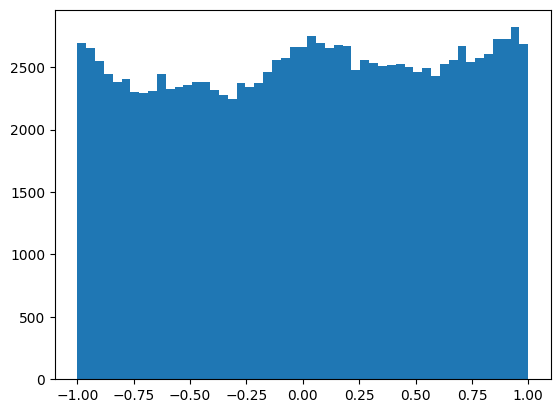

In [11]:
plt.hist(l1.ravel(), bins=51);

In [12]:
s1, s2 = model.apply(params, key, sample, spiking=True, mask_angle=-1.0)

In [13]:
s1.offset

0.25

In [14]:
s2.offset

0.5

In [15]:
sp1 = train_to_phase(s1)

In [16]:
sp2 = train_to_phase(s2)

In [16]:
spiking_rate(s2)

0.63902734375

In [17]:
from scipy.stats import pearsonr

In [18]:
[pearsonr(l1.ravel(), sp1[...,i].ravel()) for i in range(sp1.shape[-1]-1)]

[PearsonRResult(statistic=0.4788862560359054, pvalue=0.0),
 PearsonRResult(statistic=0.7425278744120289, pvalue=0.0),
 PearsonRResult(statistic=0.8514995459482024, pvalue=0.0),
 PearsonRResult(statistic=0.8610718418199934, pvalue=0.0),
 PearsonRResult(statistic=0.8286560877458462, pvalue=0.0),
 PearsonRResult(statistic=0.779968391162138, pvalue=0.0),
 PearsonRResult(statistic=0.7131778705109684, pvalue=0.0),
 PearsonRResult(statistic=0.6236664769153036, pvalue=0.0),
 PearsonRResult(statistic=0.5103901899201727, pvalue=0.0),
 PearsonRResult(statistic=0.3173865828344431, pvalue=0.0)]

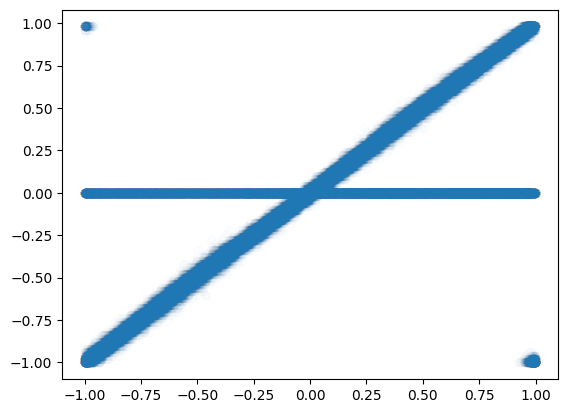

In [19]:
plt.scatter(l1.ravel(), sp1[...,4].ravel(), alpha=0.01)

In [20]:
s2.offset

0.5

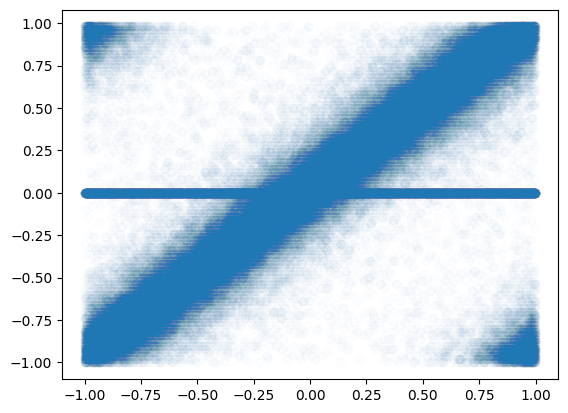

In [21]:
plt.scatter(l2.ravel(), sp2[...,4].ravel(), alpha=0.01)

In [16]:
image_to_spk = hk.without_apply_rng(hk.transform(to_train))
spks = image_to_spk.apply(params, x)

In [17]:
x1 = x.ravel()

In [18]:
sl = hk.without_apply_rng(hk.transform(spiking_layers))

In [46]:
o1, s1 = sl.apply(params, spks, dt=0.005, t_box=0.02)

In [47]:
no1 = model.apply(params, key, x)

In [48]:
o1[0].full_shape

(128, 128)

In [49]:
no1[0].shape

(128, 128)

In [55]:
po1 = train_to_phase(o1[0], offset=0.25)

In [56]:
po2 = train_to_phase(o1[1], offset=0.25)

In [57]:
po1.shape

(128, 128, 11)

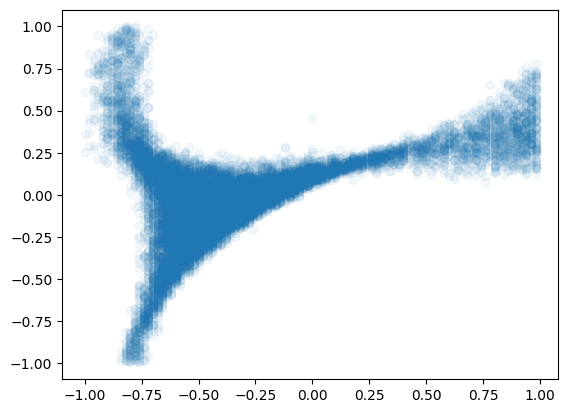

In [60]:
plt.scatter(po1[:,:,2], no1[0], alpha=0.05)

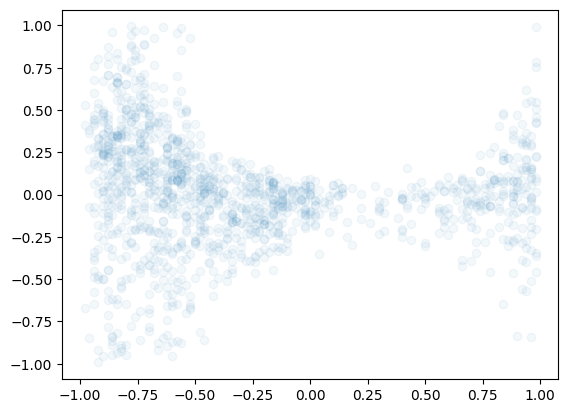

In [54]:
plt.scatter(po2[:,:,4], no1[1], alpha=0.05)

In [20]:
s1

(1.007000732421875, 1.025546875)

In [22]:
o2, s2 = sl.apply(params, spks, ma=0.07)

In [23]:
s2

(0.738751220703125, 0.756640625)

In [24]:
p1 = list(map(train_to_phase, o1))

In [25]:
p2 = list(map(train_to_phase, o2))

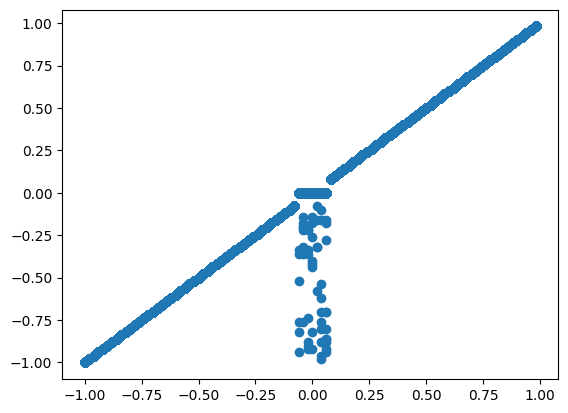

In [26]:
plt.scatter(p1[0].ravel(), p2[0].ravel())

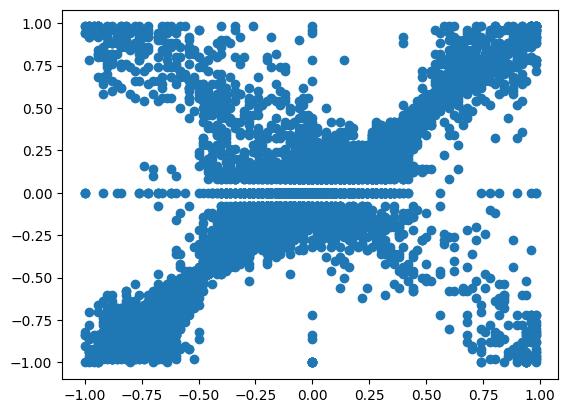

In [27]:
plt.scatter(p1[1].ravel(), p2[1].ravel())

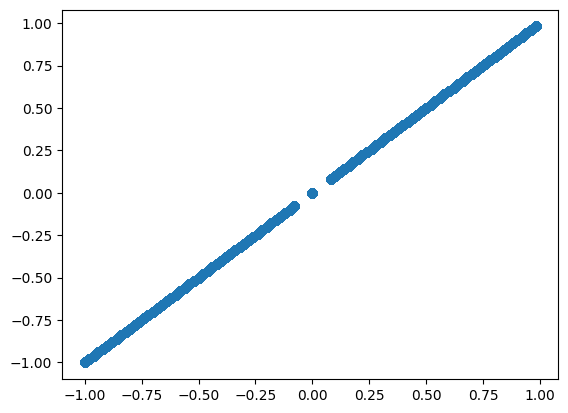

In [28]:
plt.scatter(p2[0].ravel(), p2[0].ravel())

In [67]:
tes = [sl.apply(params, spks, ma=ma) for ma in tqdm(np.linspace(0, 0.15, 16))]

100%|██████████| 16/16 [00:49<00:00,  3.09s/it]


[SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.5 , 1.48, 2.42, ..., 7.7 , 8.71, 9.71]), full_shape=(128, 10)),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.51, 1.5 , 2.44, ..., 7.68, 8.68, 9.68]), full_shape=(128, 10)),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.51, 1.5 , 2.44, ..., 7.69, 8.7 , 9.7 ]), full_shape=(128, 10)),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.53, 1.53, 2.49, ..., 7.69, 8.7 , 9.7 ]), full_shape=(128, 10)),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.53, 1.53, 2.49, ..., 7.68, 8.68, 9.69]), full_shape=(128, 10)),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.53, 1.51, 2.47, ..., 7.68, 8.68, 9.68]), full_shape=(128, 10)),
 SpikeTrain(indices=[array([   0,    0,    0, ..., 1279, 1279, 1279])], times=array([0.53, 1.5

In [69]:
sp = [t[1] for t in tes]

In [70]:
sp

[array([0.5 , 1.48, 2.42, ..., 7.7 , 8.71, 9.71]),
 array([0.51, 1.5 , 2.44, ..., 7.68, 8.68, 9.68]),
 array([0.51, 1.5 , 2.44, ..., 7.69, 8.7 , 9.7 ]),
 array([0.53, 1.53, 2.49, ..., 7.69, 8.7 , 9.7 ]),
 array([0.53, 1.53, 2.49, ..., 7.68, 8.68, 9.69]),
 array([0.53, 1.51, 2.47, ..., 7.68, 8.68, 9.68]),
 array([0.53, 1.51, 2.48, ..., 7.68, 8.67, 9.67]),
 array([0.53, 1.54, 2.51, ..., 7.65, 8.65, 9.66]),
 array([0.51, 1.52, 2.48, ..., 7.65, 8.65, 9.66]),
 array([0.51, 1.52, 2.48, ..., 7.63, 8.64, 9.64]),
 array([0.51, 1.52, 2.47, ..., 7.57, 8.61, 9.61]),
 array([0.51, 1.51, 2.48, ..., 7.56, 8.58, 9.59]),
 array([0.51, 1.51, 2.48, ..., 7.47, 8.54, 9.57]),
 array([0.51, 1.52, 2.48, ..., 7.44, 8.43, 9.45]),
 array([0.5 , 1.52, 2.47, ..., 7.44, 8.43, 9.44]),
 array([0.5 , 1.53, 2.47, ..., 7.51, 8.51, 9.51])]

In [51]:
phases = np.linspace(-1.0, 1.0, 201)
phases = phases[None,:]

In [52]:
phases.shape

(1, 201)

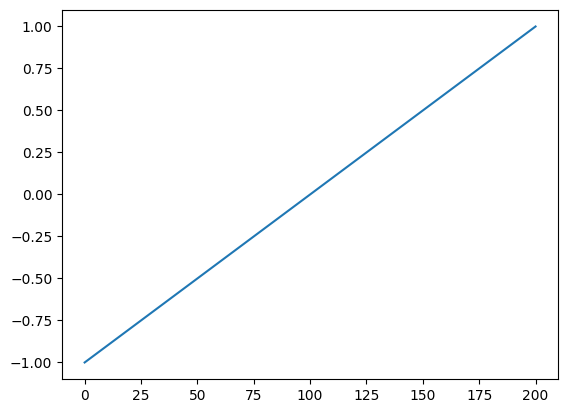

In [53]:
plt.plot(phases.ravel())

In [54]:
train = phase_to_train(phases)

In [55]:
train.full_shape

(1, 201)

In [57]:
train2 = inhibit_midpoint(train, mask_angle=0.10, offset=0.0)

In [58]:
phase2 = train_to_phase(train2)

In [59]:
phase2.shape

(1, 201, 4)

In [63]:
spiking_rate(train)

0.9950248756218906

In [64]:
spiking_rate(train2)

0.900497512437811

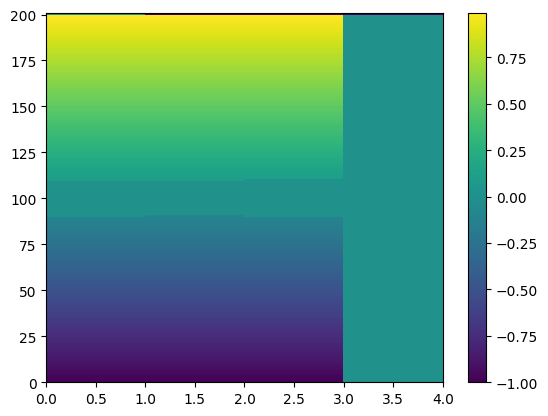

In [62]:
plt.pcolor(phase2[0,...])
plt.colorbar()

In [22]:
spks

SpikeTrain(indices=[array([     0,      1,      2, ..., 131069, 131070, 131071], dtype=int32)], times=array([-0.6380974,  0.3211341,  0.1436055, ...,  2.4658577,  2.5957196,
        2.2839832], dtype=float32), full_shape=(128, 1024))

In [23]:
tgrid = define_tgrid((0.0, 10.0), (0.03))

In [24]:
active = generate_active(spks, tgrid, 0.03)

In [25]:
mat = np.zeros((len(tgrid), *spks.full_shape))

In [26]:
mat.shape

(335, 128, 1024)

In [27]:
m0 = [np.ones_like(active[0][0]), *active[0]]

In [28]:
mat.shape

(335, 128, 1024)

In [41]:
m0

[array([1, 1, 1, ..., 1, 1, 1]),
 array([  0,   0,   0, ..., 122, 126, 127]),
 array([ 25, 118, 150, ...,  55, 481,  55])]

In [46]:
p0p = time_to_phase(spks.times, 1.0)

In [40]:
mat[m0]

IndexError: index 391 is out of bounds for axis 0 with size 335

In [38]:
for (i, inds) in enumerate(active):
    t = np.ones_like(inds[0]) * i
    all_inds = [t, *inds]
    mat[all_inds] = 1.0

IndexError: index 391 is out of bounds for axis 0 with size 335

In [25]:
active[0]

(array([  0,   0,   0, ..., 122, 126, 127]),
 array([ 25, 118, 150, ...,  55, 481,  55]))

In [24]:
len(tgrid)

335

In [23]:
len(active)

335

In [14]:
spks = model.apply(params, key, x, spiking=True)

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 562.94it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3432.07it/s]


In [15]:
len(*spks.indices)

13127

In [16]:
len(spks.times)

13127

In [17]:
spks.full_shape

(128, 10)

In [18]:
np.prod(spks.full_shape)

1280

In [19]:
p = train_to_phase(spks, offset=0.25)

In [20]:
spks.times

array([0.5 , 1.48, 2.42, ..., 7.7 , 8.71, 9.71])

In [21]:
np.max(spks.times)

10.0

In [22]:
np.ceil(spks.times[-1]) // 1.0

10.0

In [23]:
len(spks.times)

13127

In [24]:
spks.full_shape

(128, 10)

In [25]:
def spiking_sparsity(x: SpikeTrain, period: float = 1.0):
    end_time = np.max(x.times)
    periods = np.ceil(end_time) // period
    total_spikes = len(x.times)
    total_neurons = np.prod(x.full_shape)

    sparsity = total_spikes / (total_neurons * periods)
    return sparsity

In [26]:
spiking_sparsity(spks)

1.025546875

In [27]:
p = train_to_phase(spks, offset = 0.25)

In [28]:
p.shape

(128, 10, 11)

In [33]:
acc = accuracy_quadrature(p, y)

In [34]:
acc.shape

(11, 128)

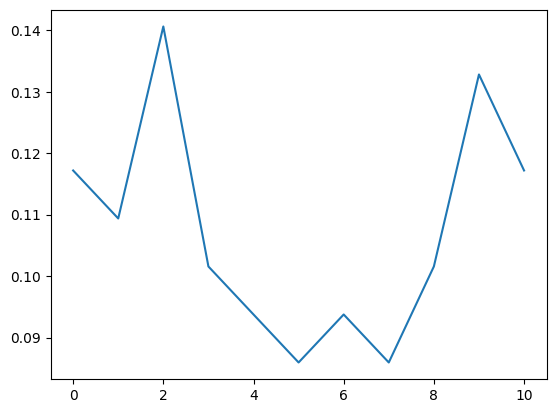

In [35]:
plt.plot(np.mean(acc, axis=1))

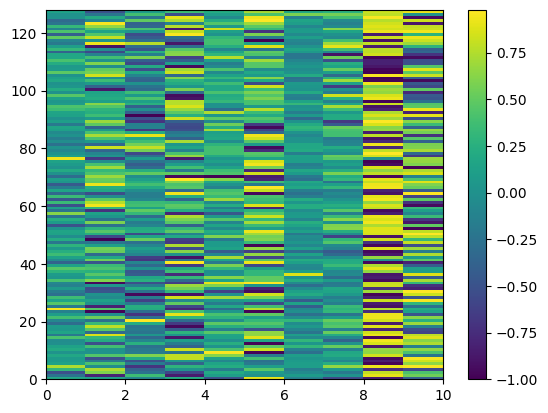

In [63]:
plt.pcolor(p[:,:,-3])
plt.colorbar()

(array([ 86.,  44.,  69., 101., 172., 253., 183., 133., 108., 131.]),
 array([-1.   , -0.802, -0.604, -0.406, -0.208, -0.01 ,  0.188,  0.386,
         0.584,  0.782,  0.98 ]),
 <BarContainer object of 10 artists>)

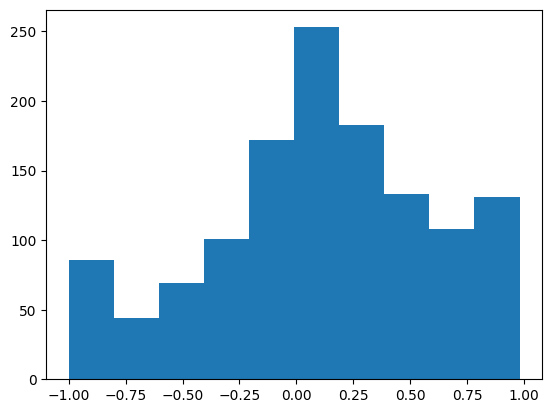

In [64]:
plt.hist(p[:,:,-3].ravel())